In [122]:
%reload_ext autoreload
%autoreload 2
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode,  plot, init_notebook_mode, iplot
import plotly.io as pio 
import pandas as pd
from astropy.table import Table, vstack, hstack, dstack
import numpy as np
from astroquery.simbad import Simbad
import astropy.coordinates as coord
import astropy.units as u
# from astroquery.ipac import ned
# from  plotly.io import _html
from IPython.display import display, Javascript
pd.options.mode.chained_assignment = None  # default='warn'
init_notebook_mode()

lambda_lya = 1215.67
theta=0
dispersion = 0.06055576 #mm per angstrom
gx_det = 43.103859739817537
gy_det = 37.712248952642668
threshold = 0.24 
slit = 0.1#0.06
center_grating=2060



display(Javascript("""
window._encodeURI = window._encodeURI || encodeURI;
encodeURI = uri => _encodeURI(uri)
    .replace('%2523', '%23')  // #
    .replace('%253A', '%3A')  // :
    .replace('%252b', '%2b'); // +
"""))



def closeness10(pos,note,threshold=0.24):
     s = np.argsort(note)[::-1]
     select = np.zeros(note.shape, dtype=bool)
     select[s[0]]=True     
     select[s[1]]=True     
     for i in s[2:]:
         if (min(abs(pos[i]-pos[select]))>threshold) & (min(abs(pos[i]-pos[s[0:2]]))>2 *threshold):
             select[i]=True
     # print('il reste', len(pos[select]),' galaxies sur', len(select), 'et la note moyenne est de:', np.sum(note[select])/len(note[select]))
     return select

# def room_left(select,catalog,threshold = 0.24):
#      cat = catalog[select]
#      pos = cat['x_mask']
#      s = argsort(pos)
#      index = np.where(pos[s][1:]-pos[s][:-1]>2*threshold)[0]
#      len(cat[index])
#      return [pos[s][1:][index],pos[s][:-1][index]]

def plot_det_shape(fig,alpha_centre,delta_centre,title='',sky=True):
    if not sky:
        alpha_centre,delta_centre = 0,0
        plate_scale=3600/0.085/1000
        x,y = 'X (mm)','Y(mm)'
    else:
        plate_scale=1
        x,y = 'RA','DEC'

    r=0.4

    test =3600/0.085/1000
    if sky:
        fig.add_shape(type="rect",
            x0=alpha_centre-0.3*plate_scale, y0=delta_centre-0.15*plate_scale, x1=alpha_centre+0.3*plate_scale, y1=delta_centre+0.15*plate_scale,
            line=dict(color="black"))

        fig.add_shape(type="rect",
            # x0=alpha_centre-0.15*plate_scale, y0=delta_centre-0.3*plate_scale, x1=alpha_centre+0.15*plate_scale, y1=delta_centre+0,
            x0=alpha_centre-(13.52/2)/test, y0=delta_centre-15/test, x1=alpha_centre+(13.52/2)/test, y1=delta_centre+(-15+16.64)/test,
            line=dict(color="black",dash="dot"),)#RoyalBlue

    else:
        fig.add_shape(type="rect",
            x0=-13, y0=-6.56, x1=13, y1=-6.56+13,
            line=dict(color="black"))

        fig.add_shape(type="rect",
            x0=-(13.52/2), y0=-15, x1=(13.52/2), y1=-15+16.64,
            line=dict(color="black",dash="dot"),)#RoyalBlue

    fig.add_shape(type="circle",
        xref="x", yref="y",
        x0=alpha_centre-r*plate_scale, y0=delta_centre-r*plate_scale, x1=alpha_centre+r*plate_scale, y1=delta_centre+r*plate_scale,
        line_color="black",)

    layout = go.Layout(
            xaxis=dict(range=[alpha_centre-r*plate_scale,alpha_centre+r*plate_scale],showgrid=False ),
            yaxis=dict(range=[delta_centre-r*plate_scale,delta_centre+r*plate_scale],showgrid=False ),
        height = 1200,
        width = 1200,
        title=title,
        xaxis_title=x,#r"$\alpha$",
        yaxis_title=y,#r"$\delta$",
        legend_title="Legend",  
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        xaxis2=dict(domain=[0.3, 0.7],anchor='y2'),
        yaxis2=dict(domain=[0.75, 0.9],anchor='x2'))
    
    fig.update_yaxes(scaleanchor = "x",scaleratio = 1,)
    fig.update_layout(layout)
    return fig

def Create_label(cat,L):
    if L is not None:
        text = [l + ' = ' + cat[l].astype(str) + '<br>'  for l in L if l in cat.columns]
        return np.sum(text,axis=0)
    else:
        return None
def ScatterPlot( cat,fig=None,x='X_pix',y='y_pix', marker_symbol='circle',L=['Internal-count','z','FUV_APP','NUV_APP'],err=20/3600,url='url',size='NUV',color='NUV',name='',add_line=False,center=None,threshold=20/3600,note='note',cut=False,slits=False,sky=True,**kwargs):
#     cat = cat.to_pandas()
    if not sky:
        alpha_centre,delta_centre = 0,0
        plate_scale=3600/0.085/1000
        plate_scale_det=3600/0.085/1000        
        line_coord ='line_coord'

    else:
        plate_scale=1
        plate_scale_det=3600/0.085/1000
        line_coord = 'line_coord_sky'


    cat['ok']=True
    if url is None:#·
        cat['url'] = ["<a href=\'http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=%0.7fd%0.7fd&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcmin'>%s</a>" %(ra,dec,'-')for ra,dec in zip(cat[x],cat[y])]
        url='url'
    
    if fig==None:
        fig=go.Figure()


    if add_line:
        cat['ok']=False
        cat = cat.sort_values(x)
        if sky:
            mask =  ((cat[line_coord]<center[1]+0.15) &  (cat[line_coord]>center[1]-0.15) & (cat[x]<center[0]+0.3) &  (cat[x]>center[0]-0.3))| (cat[note]>=100)
        else:
            # cat['line_coord_mask'] = np.round(cat[y]  + ((cat['zspec']+1)*cat['Line']-center_grating)*dispersion/gy_det,2)
            # mask = cat['line_coord_sky']>-1000
            mask =  ((cat[line_coord]<6.5) &  (cat[line_coord]>-6.5) )| (cat[note]>=100)#& (cat[x]<center[0]+0.3) &  (cat[x]>center[0]-0.3))| (cat[note]>=100)

        mask2 = closeness10(np.array(cat[x]),  np.array(cat[note]),threshold=threshold)
        cat['ok'][mask] = mask2
        cat['space left']= 0 #* np.array(cat[x],dtype=int)
        cat['space right']=int(0)
        cat['space left'][cat['ok']] =  [0]+list(3600*(np.array(cat[x][cat['ok']][1:]) -np.array(cat[x][cat['ok']][:-1])))
        cat['space right'][cat['ok']] = list(3600*(np.array(cat[x][cat['ok']][:-1]) -np.array(cat[x][cat['ok']][1:])))+[0]
        cat['space left'] = np.array(cat['space left'],dtype=int)
        cat['space right'] = np.array(cat['space right'],dtype=int)
        
        if cut:
            cat['symbol'][~cat['ok']]=cat['symbol'][~cat['ok']].astype(str)+'-open'
            # cat['symbol'][cat['ok'] & mask2]=cat['symbol'][cat['ok'] & mask2].astype(str)+'-dot'
        text = Create_label(cat,L)[cat['ok']]
        # print(cat[~cat['selected']])
        if slits:
            # for ac,dc in zip(cat[cat['ok']][x],cat[cat['ok']][y]):
            for i,gal in cat[cat['ok']].iterrows():

                # print(gal)
                ac,dc = gal[x], gal[y]+gal['delta_y']*plate_scale
                # length = gal['length']*plate_scale
                width = gal['width']*plate_scale
                fig.add_shape(type="rect",x0=ac-gal['length_left']*plate_scale, y0=dc-width/2, x1=ac+gal['length_right']*plate_scale, y1=dc+width/2,line=dict(color="black",width=0.5),)#RoyalBlue
                #print(ac-gal['length_left']*plate_scale, dc-width/2, ac+gal['length_right']*plate_scale, dc+width/2)
                fig.add_shape(type="rect",x0=ac-gal['length_left']*plate_scale, y0=center[1]-0.18*plate_scale-width/2, x1=ac+gal['length_right']*plate_scale, y1=center[1]-0.18*plate_scale+width/2,line=dict(color="black",width=0.5),)#,hovertext = Create_label(cat[cat['ok']],['space left','space right']),


        lya=go.Scatter(x=cat[x][cat['ok']],
                y=cat[line_coord][cat['ok']],
                mode='markers',
                error_y=dict(type='data',array=0.05*np.ones((len(cat[cat['ok']]))),thickness=1,width=0),#,thickness=50,width=1#0.120

                marker_symbol='diamond-wide',#hovertemplate = '%{text}<extra></extra>',
                marker=dict(color='black'),name='Emission line',hovertext = text,**kwargs)#,hoverinfo='skip')
        fig.add_trace(lya)
    else:
        mask=None
        text = Create_label(cat,L)

    if type(size) is str:
        size=cat[size]
    
        
    if color is None:
        colorscale=None
        colorbar=None
        showscale=False
        cmin, cmax = None, None
    else:
        colorscale="gray"#"Cividis"#"gray"#'viridis'#
        colorbar = dict(title=color,len=0.6)
        color = cat[color][cat['ok']]
        showscale=True
        cmin, cmax = np.min(color), np.max(color)

#     colorscale=None if color is None else 'viridis'
#     color=None if color is None else 'viridis'
    #cat['ok']=True
    trace=go.Scatter(x=cat[x][cat['ok']],
                    y=cat[y][cat['ok']],
                    # error_x=dict(type='data',array=err*np.ones((len(cat)))),#,thickness=50,width=1#0.120
                    mode='markers+text',
                    marker_symbol=cat['symbol'][cat['ok']],#hovertemplate = '%{text}<extra></extra>',
                    textfont=dict(
                    family="sans serif",
                    size=18,
                    color="black",colorsrc='black'),#textposition="bottom center",
                    marker=dict(
                    line=dict(width=1),
                    size=size,
                    color=color,
                    colorscale=colorscale,cmax=cmax,cmin=cmin,
                    showscale=showscale,colorbar=colorbar),text=cat[url][cat['ok']],
                    hovertext = text,name=name,**kwargs)
    fig.add_trace(trace)
    return fig, trace, cat['ok']

#     subvipers['line_coord'] = np.round(cat['y_mask_Julia']  + ((cat['zspec']+1)*subvipers['Line']-center_grating)*dispersion,2)



<IPython.core.display.Javascript object>

In [135]:


def compute_mask_position_Julia(cat,alpha_centre, delta_centre, ra='RA',dec='DEC',angle=0):
    from astropy import wcs
    w = wcs.WCS(naxis=2)
    w.wcs.crpix = [1, 1]                  
    w.wcs.crval = [alpha_centre, delta_centre]           
    w.wcs.cdelt = np.array([-0.0235, 0.0235])
    w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
    def convertTOmm(MX,MY,w):
        N = len(MX)
        gno = np.zeros([N,2])
        for i in range(N):
            # print(MX)
            gno[i,0]=MX[i]
            gno[i,1]=MY[i]
        xymm = w.wcs_world2pix(gno, 0)
        MXmm = []
        MYmm = []
        MXmm = -xymm[:,0]
        MYmm = xymm[:,1]
        MXmm_rotated = MXmm * np.cos(angle*np.pi/180) + MYmm * np.sin(angle*np.pi/180)
        MYmm_rotated = MYmm * np.cos(angle*np.pi/180) - MXmm * np.sin(angle*np.pi/180)
        return MXmm_rotated,MYmm_rotated
    ####################################
    ### Mask - correct for curved plate scale ###
    def correctFORplatescale(MX,MY):
        X=MX
        Y=MY
        # if we adopt plate scale from projection above 
        # which is 0.0235  --> 42.5532 mm/deg = 11.8203 um/"
        # we need to divide out the assumed plate scale
        ps0=11.8203
        radius=np.sqrt((X**2)+(Y**2))
        psnew=-1.7584761e-4*radius**2-(6.0880439e-06*radius)+1.1739247e01
        return psnew*X/ps0,psnew*Y/ps0
    cat['x_mm'], cat['y_mm'] = correctFORplatescale(*convertTOmm(np.array(cat[ra]),np.array(cat[dec]),w))
    return cat

In [133]:


def compute_mask_position_Vincent(catalogue,alpha_centre, delta_centre, ra='RA',dec='DEC',angle=0,center_grating = 2060):
    def g_mask1(x, a=42.26134, b=-3.154411e-3, c=-1.117322):
        return a + b * x + c * np.square(x)
    numx = -np.cos(catalogue[dec]*np.pi/180)*np.sin((catalogue[ra] - alpha_centre)*np.pi/180)
    denom = np.cos((catalogue[ra] - alpha_centre)*np.pi/180) * np.cos(catalogue[dec]*np.pi/180) * np.cos(delta_centre*np.pi/180)  + np.sin(catalogue[dec]*np.pi/180) * np.sin(delta_centre*np.pi/180)
    numy = -np.cos((catalogue[ra] - alpha_centre)*np.pi/180) * np.cos(catalogue[dec]*np.pi/180) * np.sin(delta_centre*np.pi/180)  + np.sin(catalogue[dec]*np.pi/180) * np.cos(delta_centre*np.pi/180)
    x= - np.arctan(numx/denom)*180/np.pi
    y = np.arctan(numy/denom)*180/np.pi
    catalogue['coord_x'] =  x * np.cos(angle*np.pi/180) + y * np.sin(angle*np.pi/180)
    catalogue['coord_y'] =  y * np.cos(angle*np.pi/180) - x * np.sin(angle*np.pi/180)
    catalogue['radius'] =  np.sqrt(catalogue['coord_y']**2 +catalogue['coord_x']**2 )
    catalogue['magnification'] =  g_mask1(np.sqrt(catalogue['coord_y']**2 +catalogue['coord_x']**2 ))
    catalogue['y_mask'] =  catalogue['coord_y'] * catalogue['magnification']
    catalogue['x_mask'] =  catalogue['coord_x'] * catalogue['magnification']
    catalogue['y_det'] =  catalogue['coord_y'] * gy_det
    catalogue['x_det'] =  catalogue['coord_x'] * gx_det 
    # if 'redshift' in catalogue.colnames:
    #     create_columns(catalogue, 'lya_coord', catalogue['y_det']  + ((catalogue['redshift']+1)*lambda_lya-center_grating)*dispersion, dtype=float,position=0)
    # if 'Z' in catalogue.colnames:
    #     create_columns(catalogue, 'lya_coord', catalogue['y_det']  + ((catalogue['Z']+1)*lambda_lya-center_grating)*dispersion, dtype=float,position=0)
    return catalogue





alpha_centre,delta_centre = 32.22 -5.75


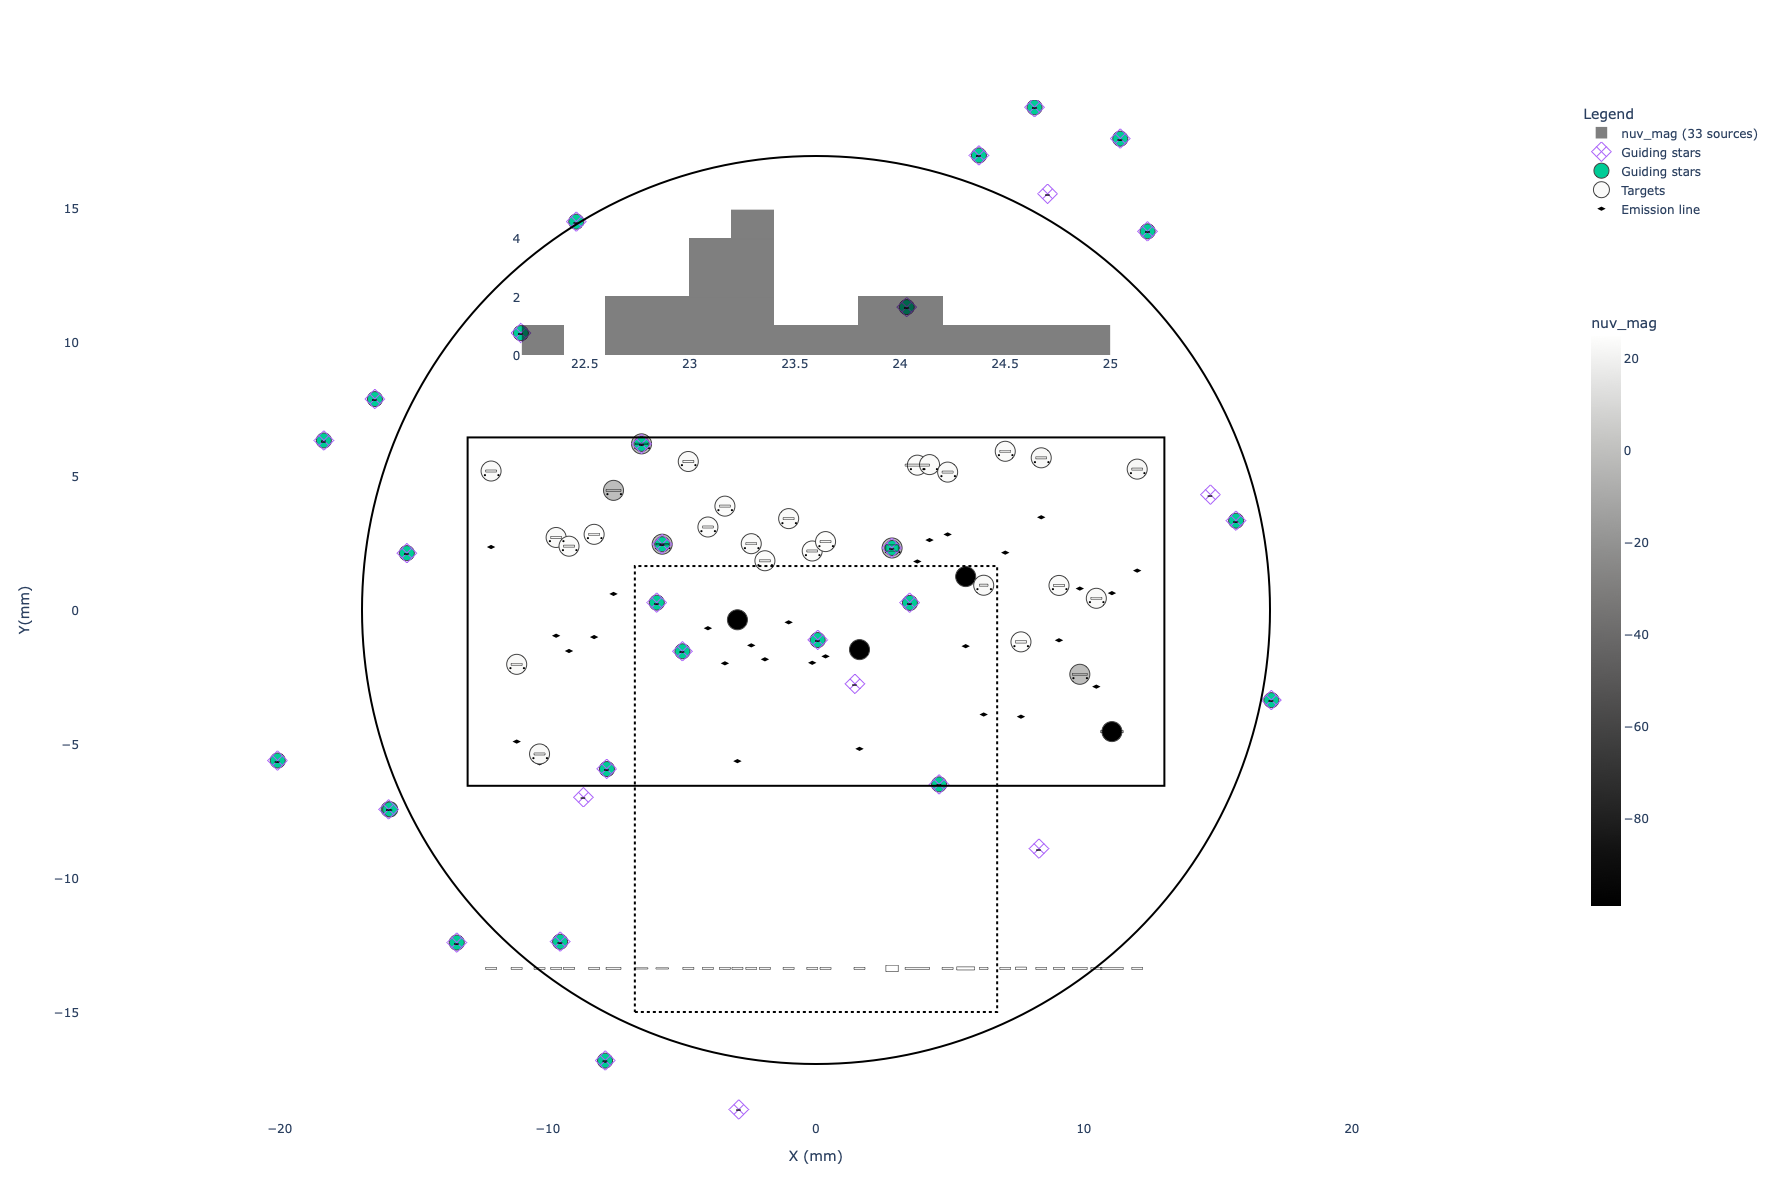

In [167]:
def plot_table(path,color='nuv_mag',stars=True,alpha_centre=None,delta_centre=None,angle=0,**kwargs):
    from astroquery.simbad import Simbad

    title=''
    F2 = Table.read(path)
    F2['line_coord_sky'] = F2['DEC']  + ((F2['Z']+1)* 1215.67-center_grating)*dispersion/gy_det
    F2['symbol'] = 'circle'
    F2['Note'] = 1
    F2['url_cds'] = ["<a href=\'http://cdsportal.u-strasbg.fr/?target=%0.7f+%0.7f'>%s</a>" %(ra,dec,'·')for ra,dec in zip(F2['RA'],F2['DEC'])]
    F2['url_simbad'] = ["<a href=\'http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=%0.7fd%0.7fd&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcmin'>%s</a>" %(ra,dec,'·')for ra,dec in zip(F2['RA'],F2['DEC'])]
    F2['url'] = ["<a href=\'http://cdsportal.u-strasbg.fr/?target=%0.7f+%0.7f'>.</a>  <a href=\'http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=%0.7fd%0.7fd&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcmin'>.</a>" %(ra,dec,ra,dec)for ra,dec in zip(F2['RA'],F2['DEC'])]
    plate_scale = 3600/0.085/1000
    F2['line_coord'] = F2['yline_mm'] 
    F2['Note']=1e4
    F2['delta_y']=0
    F2['width']=F2['slit_width']/plate_scale
    F2['length_left']=F2['slit_length']/2/plate_scale
    F2['length_right']=F2['slit_length']/2/plate_scale
    if (alpha_centre==None)  & (delta_centre==None):
        alpha_centre = F2['RA'].mean()
        delta_centre = F2['DEC'].mean()
    print('alpha_centre,delta_centre =',alpha_centre,delta_centre)
    if 'nuv_mag' in F2.columns:
        F2['nuv_mag'][F2['nuv_mag']==0]=25.999



    
# simbads = [Simbad.query_region(coord.SkyCoord(ra=qso['ra'], dec=qso['dec'],unit=(u.deg, u.deg), frame='icrs'),radius=0.003 * u.deg) for qso in nicole]
# Nicole_new = hstack([nicole,vstack(simbads)])
    # print(len(sources_around_field),sources_around_field['x_mm'])
    fig, trace1, _ = ScatterPlot(F2.to_pandas(),x='x_mm',y='y_mm',L=['RA','DEC','Z','nuv_mag','fuv_mag',' B','R','flag'],url='url',note='Note',threshold=0,cut=True,size=20,slits=True,line=dict(width=2),sky=False,color=color,add_line=True,center=[alpha_centre,delta_centre],name='Targets',**kwargs)#, visible = "legendonly")
    gaia = Table.read('/Users/Vincent/Github/notebooks/gaia_g12.fits').to_pandas()
    gaia = gaia.query('ra>%0.4f & ra<%0.4f & dec>%0.4f & dec<%0.4f'%(alpha_centre-0.5,alpha_centre+0.5,delta_centre-0.5,delta_centre+0.5)) 
    gaia_around_field = compute_mask_position_Julia(gaia,alpha_centre=alpha_centre, delta_centre=delta_centre,ra='ra',dec='dec',angle=angle)
    gaia_around_field['symbol']='circle'#'diamond-x-open'
    fig, trace1, _ = ScatterPlot(gaia_around_field.query('phot_g_mean_mag<12'),x='x_mm',y='y_mm',L=['phot_g_mean_mag','phot_rp_mean_mag','phot_bp_mean_mag','source_id'],fig=fig,url=None,name='Guiding stars',add_line=False,center=[alpha_centre,delta_centre],color=None,size=15)


    if stars:
        Simbad = Simbad()
        Simbad.add_votable_fields('ra(d)', 'dec(d)','z_value','flux(U)','flux(B)','flux(G)','flux(u)','flux(g)','flux(R)','flux(r)','biblio','otype')#,'otypes')#,'redshift')#,'flux(FUV)')
        sources_around_field = Simbad.query_region(coord.SkyCoord(ra=alpha_centre, dec=delta_centre,unit=(u.deg, u.deg), frame='icrs'),radius=0.5 * u.deg)
        sources_around_field = compute_mask_position_Julia(sources_around_field,alpha_centre=alpha_centre, delta_centre=delta_centre,ra='RA_d',dec='DEC_d',angle=angle)
        sources_around_field['symbol']='diamond-x-open'
        fig, trace1, _ = ScatterPlot(sources_around_field.to_pandas().query('FLUX_r<15 | FLUX_G<15 | FLUX_g<15 | FLUX_R<15'),x='x_mm',y='y_mm',L=['Z_VALUE','FLUX_U','FLUX_B','FLUX_G','FLUX_u','FLUX_g','FLUX_r','OTYPE'],fig=fig,url=None,name='Guiding stars',add_line=False,center=[alpha_centre,delta_centre],color=None,size=15)



        

        
        # sources_around_field = compute_mask_position_Vincent(sources_around_field,alpha_centre=alpha_centre, delta_centre=delta_centre,ra='RA_d',dec='DEC_d',angle=angle)
        # fig, trace1, _ = ScatterPlot(sources_around_field.to_pandas().query('FLUX_r<15 | FLUX_G<15 | FLUX_g<15 | FLUX_R<15'),x='x_mask',y='y_mask',L=['Z_VALUE','FLUX_U','FLUX_B','FLUX_G','FLUX_u','FLUX_g','FLUX_r','OTYPE'],fig=fig,url=None,name='Guiding stars',add_line=False,center=[alpha_centre,delta_centre],color=None,size=15)
# .query('Z_VALUE<0.75 & Z_VALUE>0.6')
        fig.add_trace(go.Histogram(x=F2[color],xaxis='x2',yaxis='y2', marker_color='black',opacity=0.5,name='%s (%i sources)'%(color,len(F2)),xbins=dict(start=15,end=25,size=0.2)))
    fig.update_layout(barmode='stack')
    fig=plot_det_shape(fig,alpha_centre,delta_centre,title=title,sky=False)
    fig.write_html(path.replace('csv','html'))
    iplot(fig)
    return F2
    
F1 = plot_table(path='clean_fields/F1_mask_final.csv',alpha_centre=32.22,delta_centre=-5.75,stars=True)   

alpha_centre,delta_centre = 253.0624 34.9699


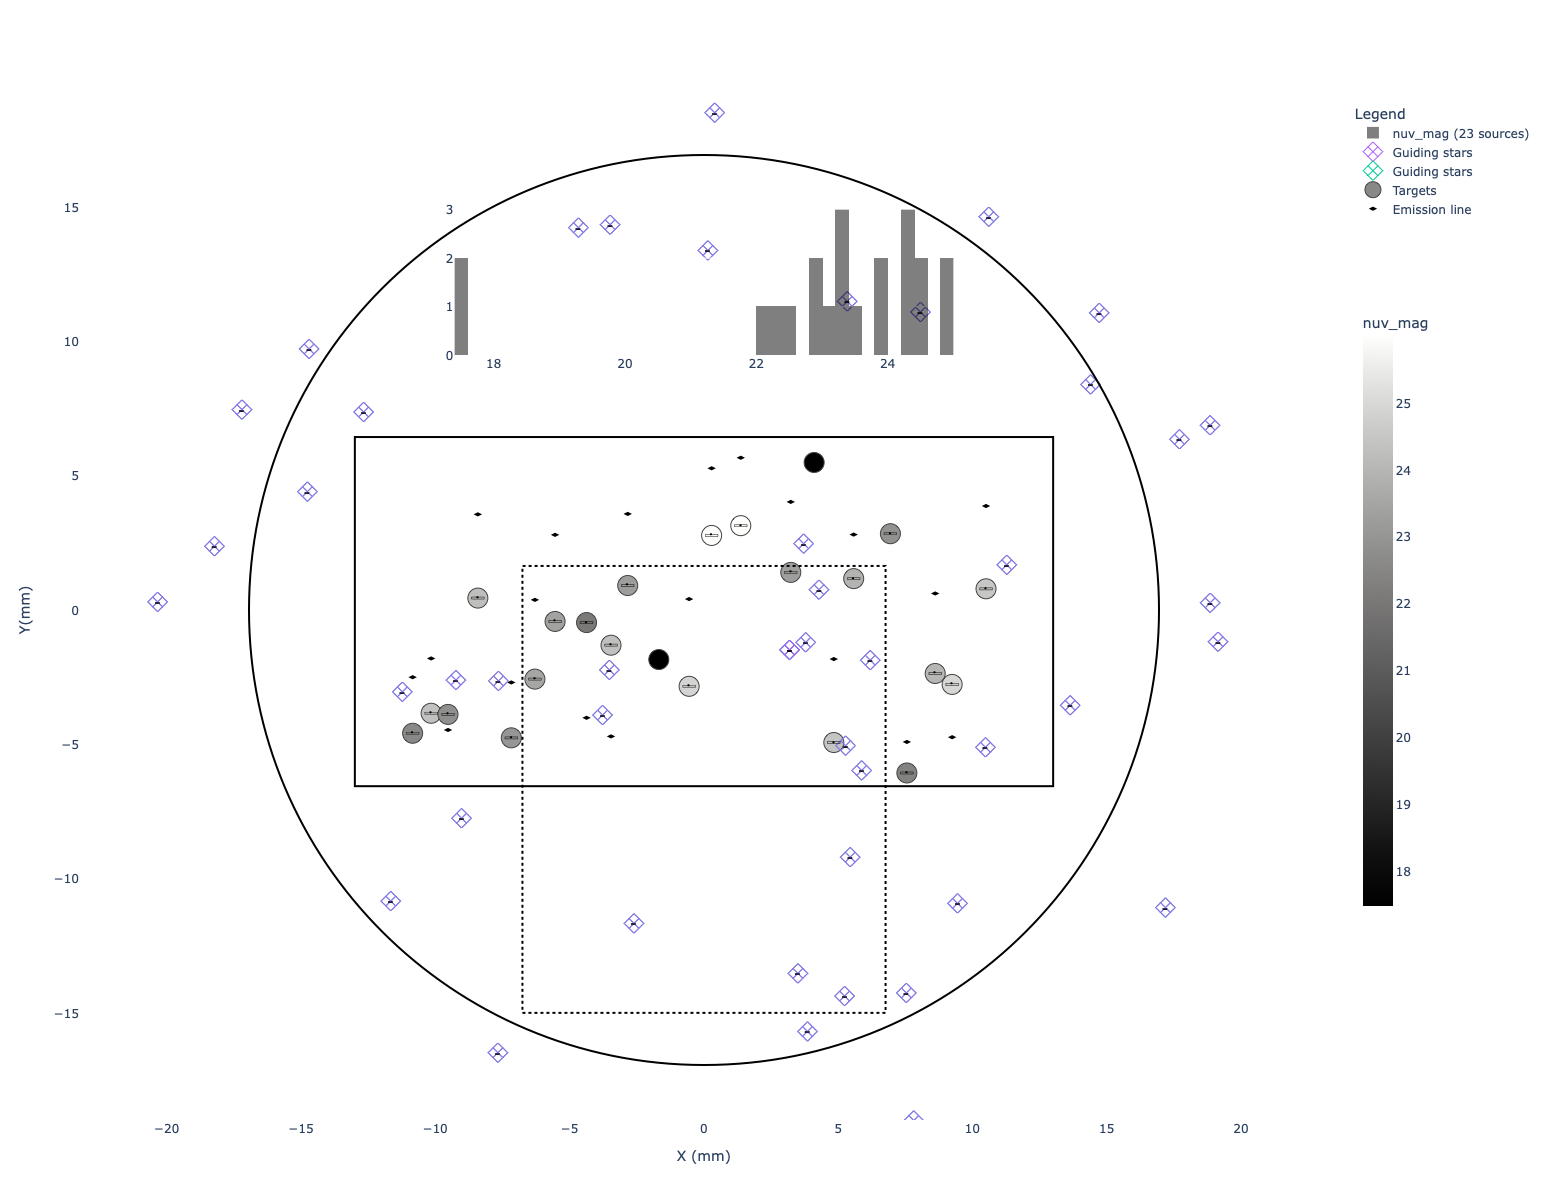

In [136]:
F2 = plot_table(path='clean_fields/F2_mask_final.csv',alpha_centre=253.0624,delta_centre= 34.9699,angle=20)   



alpha_centre,delta_centre = 352.3424 0.21245


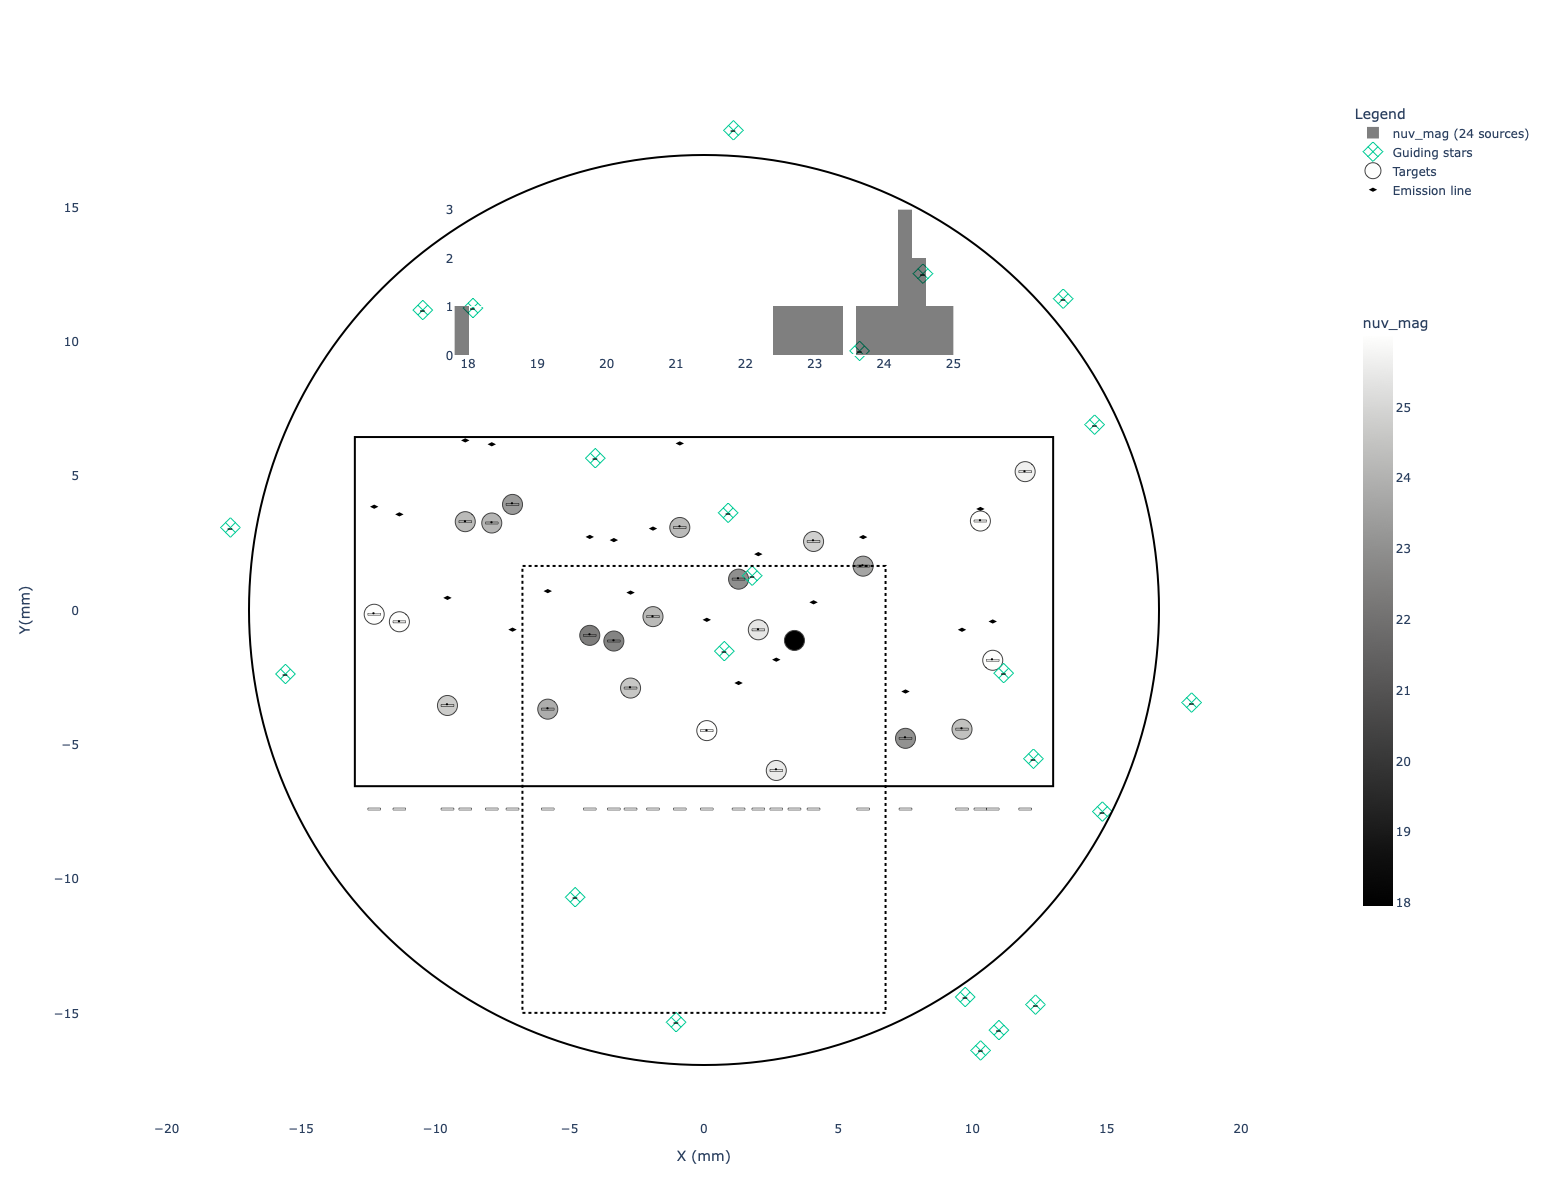

In [124]:
F3 = plot_table(path='clean_fields/F3_mask_final.csv',alpha_centre=352.3424,delta_centre= 0.21245)   



alpha_centre,delta_centre = 36.9049 0.65245


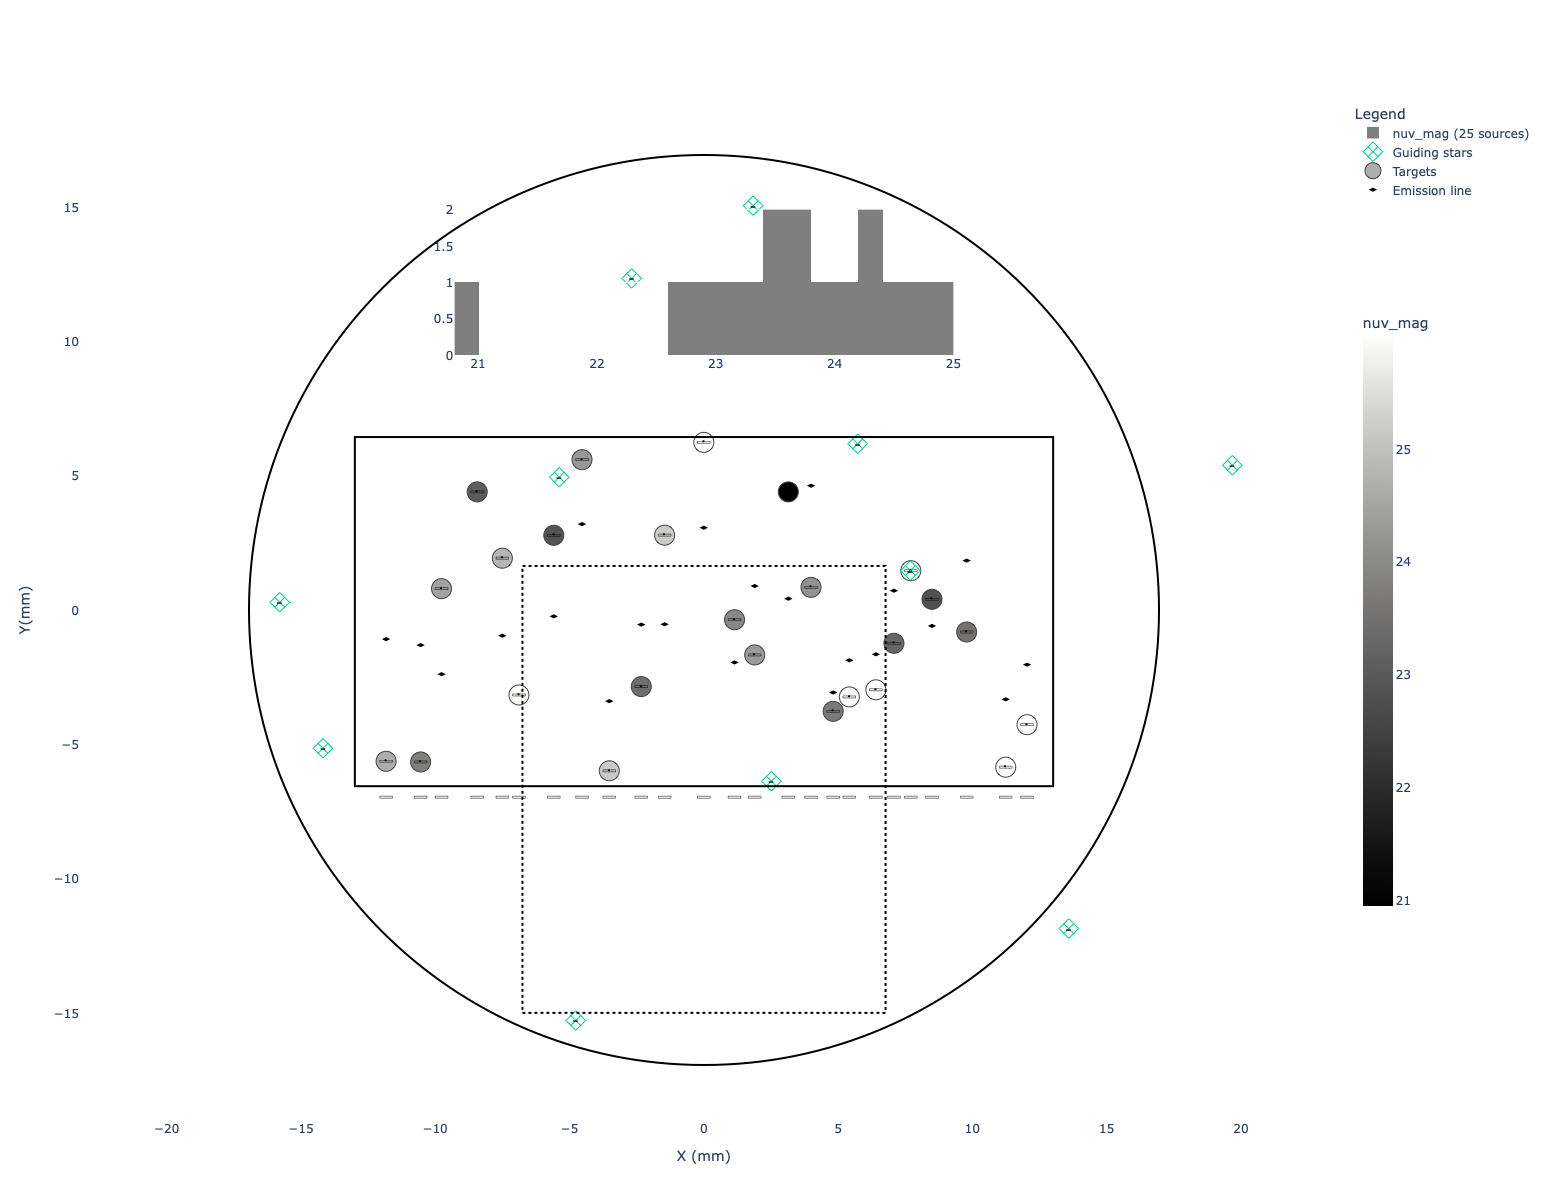

In [119]:
F4 = plot_table(path='clean_fields/F4_mask_final.csv',alpha_centre=36.9049, delta_centre=0.65245)  



alpha_centre,delta_centre = 51.4631047255 0.3307361177777779


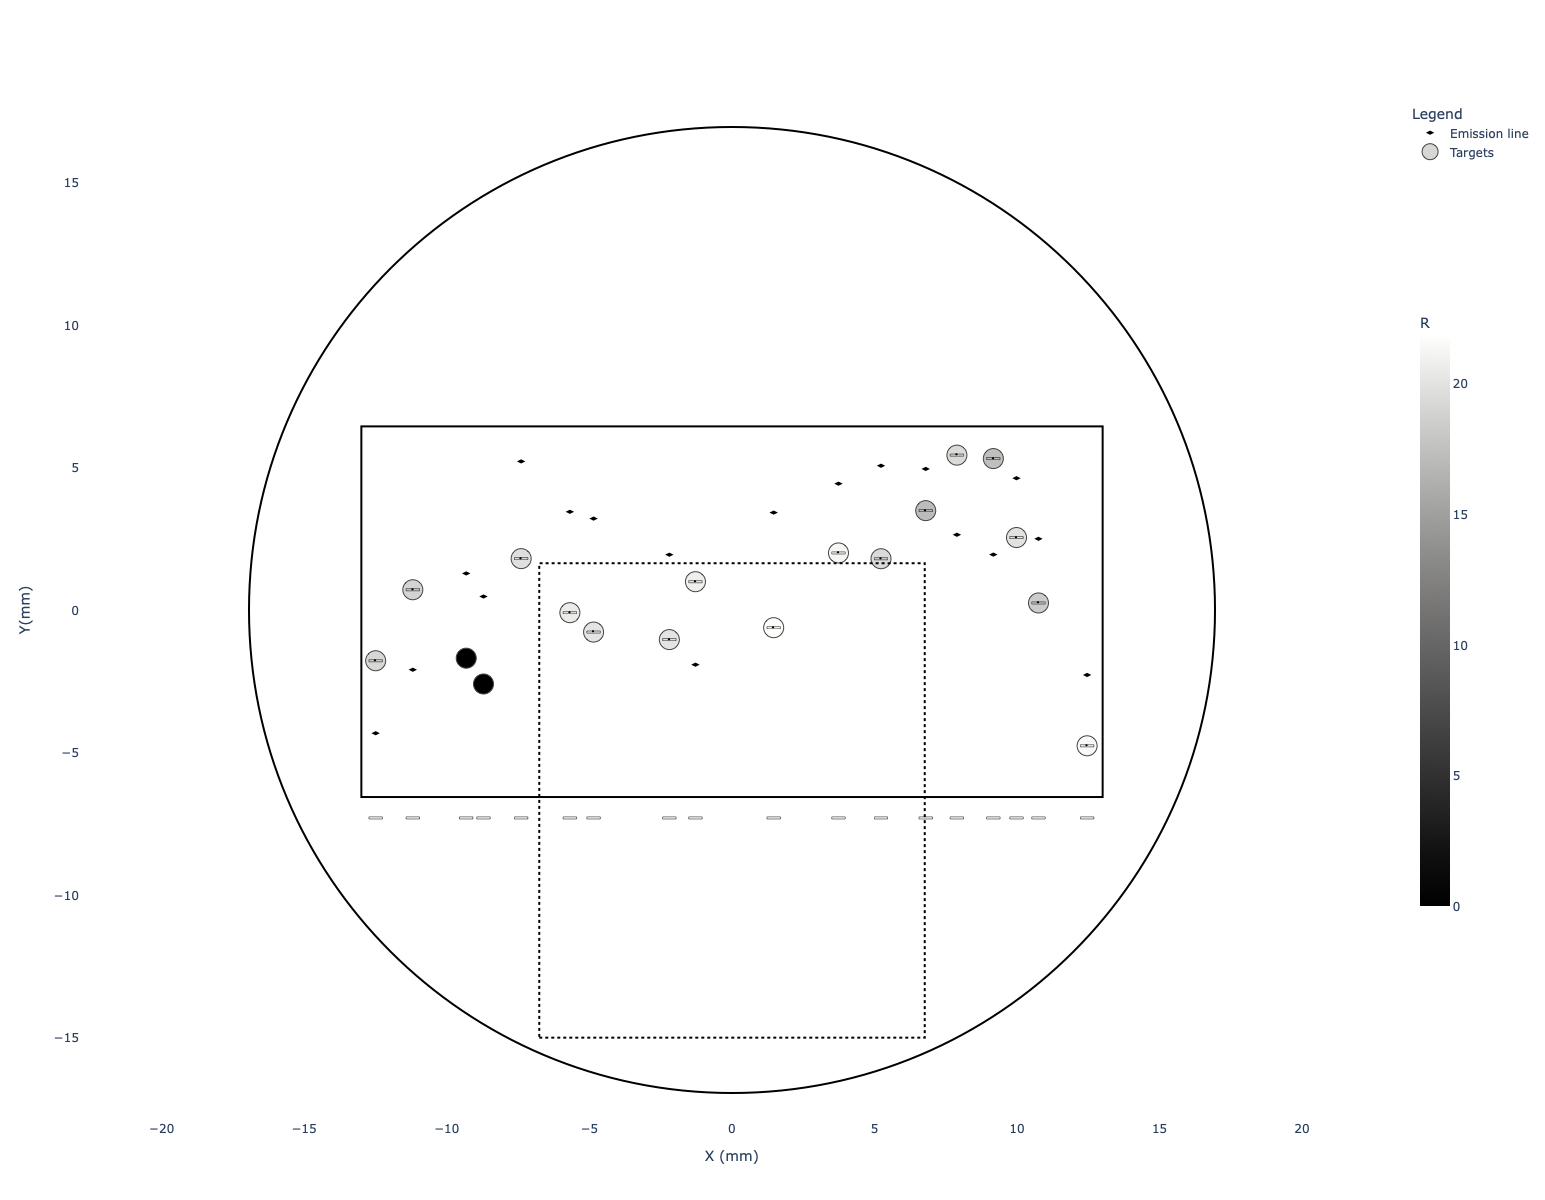

In [120]:
QSO=plot_table(path='clean_fields/QSO_mask_final.csv',color='R',stars=False)   



In [154]:
def plot_histogram_field(cats,names,value,**kwargs):
    
    fig = go.Figure()
    for cat,name in zip(cats,names):
        array = cat.to_pandas().eval(value)
        fig.add_trace(go.Histogram(x=array, opacity=0.5,name='%s (%i sources)'%(name,len(cat)) ,**kwargs))
    layout = go.Layout(
        # xaxis=dict(range=[0,1.3],showgrid=False ),
        height = 500,width = 1000,
        title='%s distribution'%(value),
        xaxis_title=value,
        legend_title="Fields",  
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',)
    fig.update_layout(layout)  
    # fig.update_layout(barmode='overlay')

    iplot(fig)

def plot_scatter_field(cats,names,x,y,**kwargs):
    fig = go.Figure()
    for cat,name in zip(cats,names):
#         array = cat.to_pandas().eval(value)
        fig.add_trace(go.Scatter(x=cat[x],y=cat[y], opacity=0.5,name='%s (%i sources)'%(name,len(cat)) ,**kwargs))
    layout = go.Layout(
        # xaxis=dict(range=[0,1.3],showgrid=False ),
        height = 500,width = 1000,
#         title='%s distribution'%(value),
        xaxis_title=x,
        yaxis_title=y,
        legend_title="Fields",  
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',)
    fig.update_layout(layout)   
    iplot(fig)   
 
def add_space(cat):
    cat.sort('x_mm')
    cat['space_left'] =  [0]+list((np.array(cat['x_mm'][1:]-cat['slit_length'][1:]/2) -np.array(cat['x_mm'][:-1]+cat['slit_length'][:-1]/2)))
    cat['space_right'] = list((np.array(cat['x_mm'][:-1]+cat['slit_length'][:-1]/2) -np.array(cat['x_mm'][1:]-cat['slit_length'][1:]/2)))+[0]
    return cat
F1 = add_space(F1)
F2 = add_space(F2)
F3 = add_space(F3)
F4 = add_space(F4)
QSO = add_space(QSO)

# F1.sort('x_mm')
# F2.sort('x_mm')
# F3.sort('x_mm')
# F4.sort('x_mm')
# QSO.sort('x_mm')
# F1['space_left'] =  [0]+list((np.array(F1['x_mm'][1:]) -np.array(F1['x_mm'][:-1])))
# F1['space_left'] =  [0]+list((np.array(F1['x_mm'][1:]-F1['slit_length'][1:]/2) -np.array(F1['x_mm'][:-1]+F1['slit_length'][:-1]/2)))
# F1['space_right'] = list((np.array(F1['x_mm'][:-1]) -np.array(F1['x_mm'][1:])))+[0]
# F1['space_right'] = list((np.array(F1['x_mm'][:-1]+F1['slit_length'][:-1]/2) -np.array(F1['x_mm'][1:]-F1['slit_length'][1:]/2)))+[0]

# F2['space_left'] =  [0]+list((np.array(F2['x_mm'][1:]) -np.array(F2['x_mm'][:-1])))
# F2['space_right'] = list((np.array(F2['x_mm'][:-1]) -np.array(F2['x_mm'][1:])))+[0]
# F3['space_left'] =  [0]+list((np.array(F3['x_mm'][1:]) -np.array(F3['x_mm'][:-1])))
# F3['space_right'] = list((np.array(F3['x_mm'][:-1]) -np.array(F3['x_mm'][1:])))+[0]
# F4['space_left'] =  [0]+list((np.array(F4['x_mm'][1:]) -np.array(F4['x_mm'][:-1])))
# F4['space_right'] = list((np.array(F4['x_mm'][:-1]) -np.array(F4['x_mm'][1:])))+[0]
# QSO['space_left'] =  [0]+list((np.array(QSO['x_mm'][1:]) -np.array(QSO['x_mm'][:-1])))
# QSO['space_right'] = list((np.array(QSO['x_mm'][:-1]) -np.array(QSO['x_mm'][1:])))+[0]




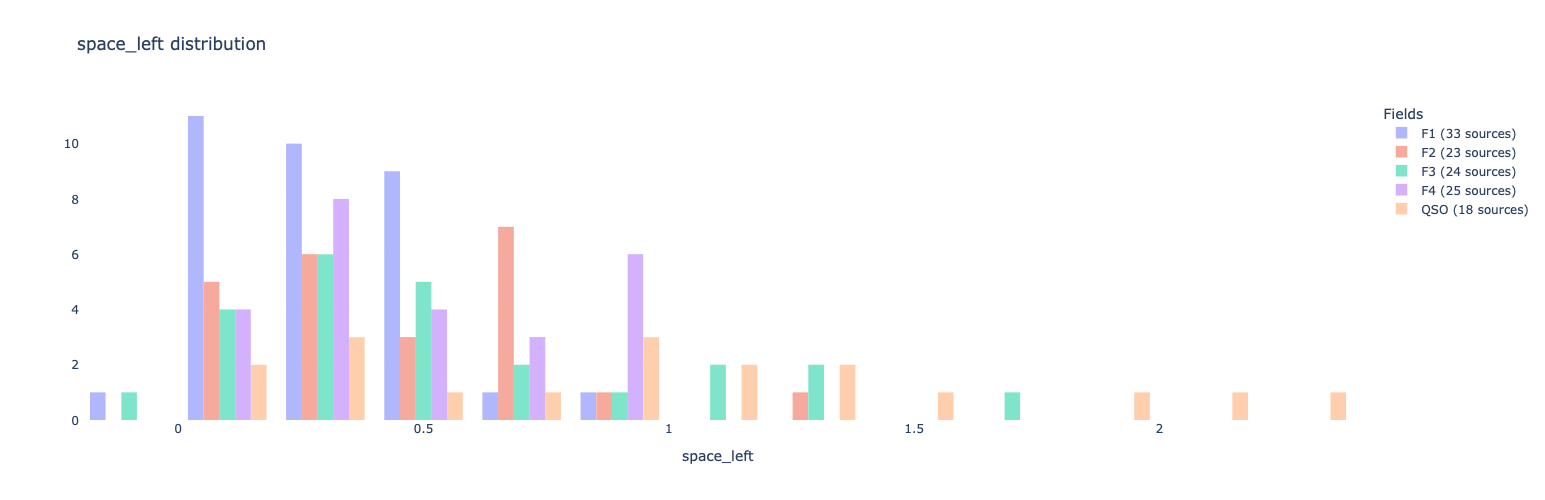

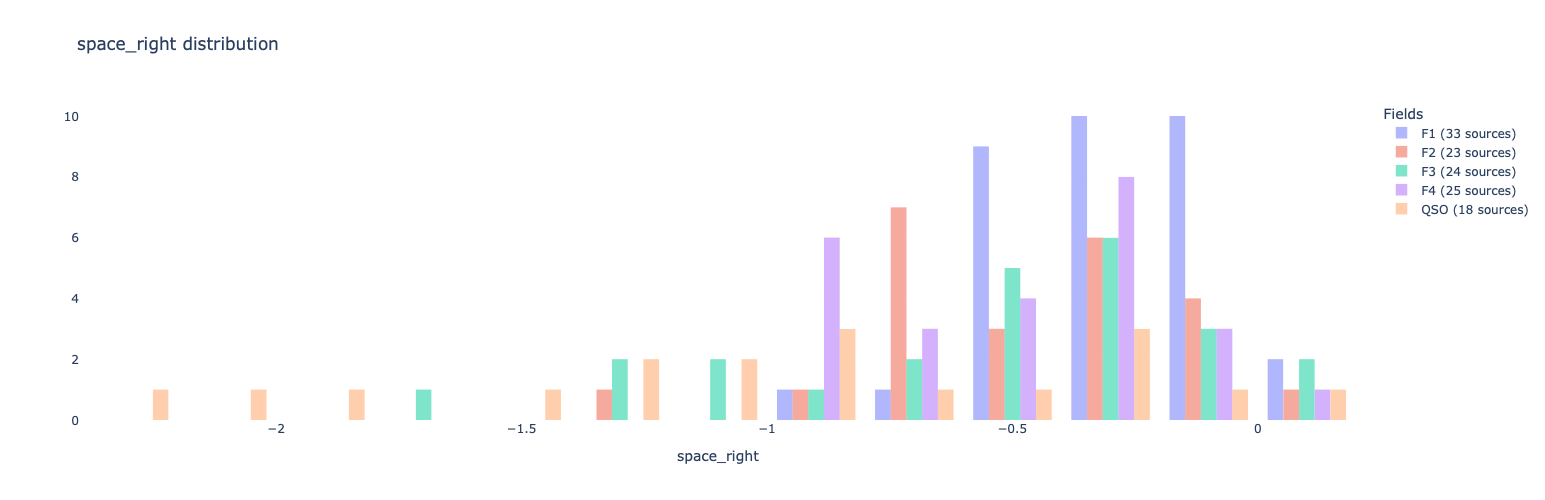

In [158]:
plot_histogram_field([F1,F2,F3,F4,QSO],['F1','F2','F3','F4','QSO'],value='space_left')#, xbins=dict(start=0,end=2,size=0.05))  
plot_histogram_field([F1,F2,F3,F4,QSO],['F1','F2','F3','F4','QSO'],value='space_right')#, xbins=dict(start=0,end=2,size=0.1))  






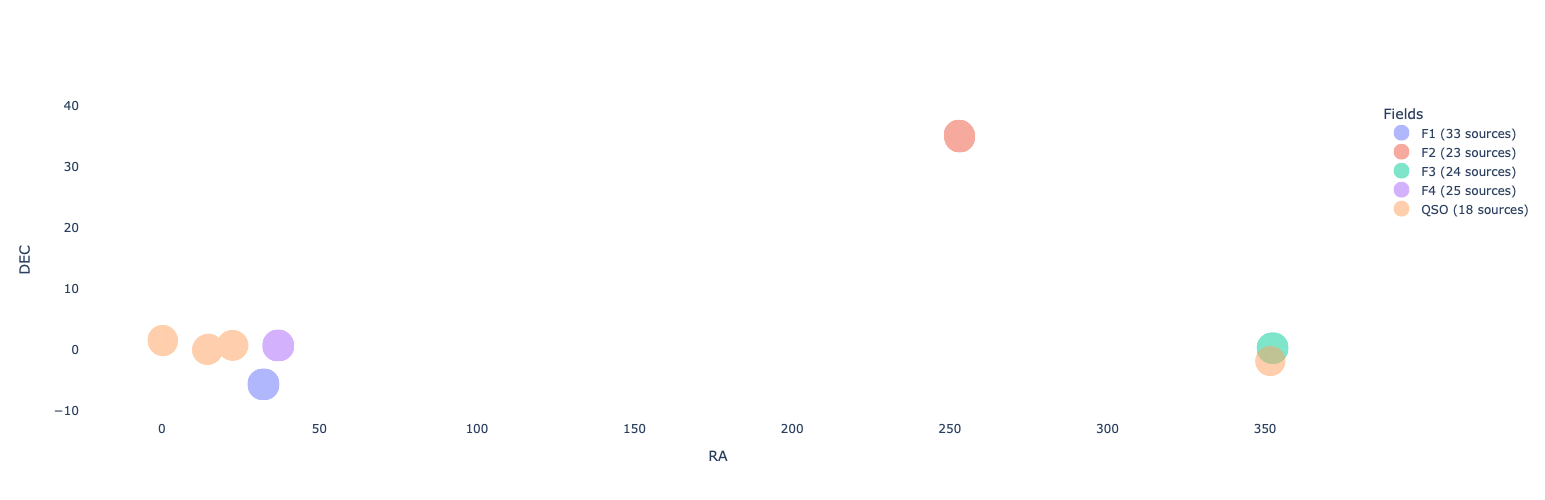

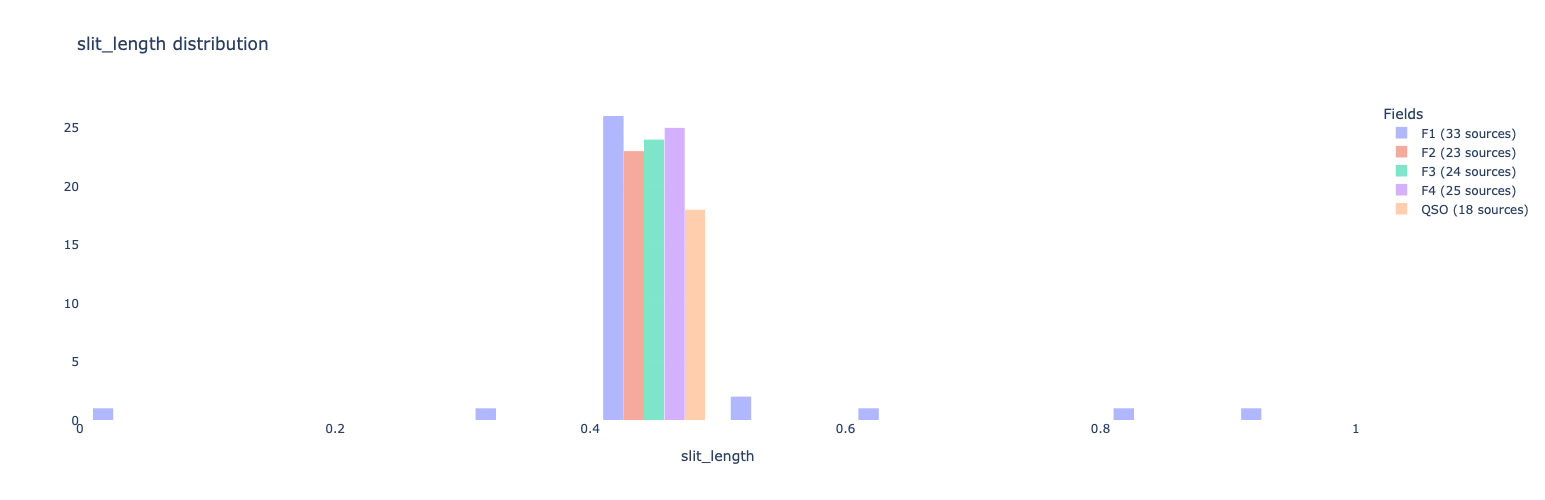

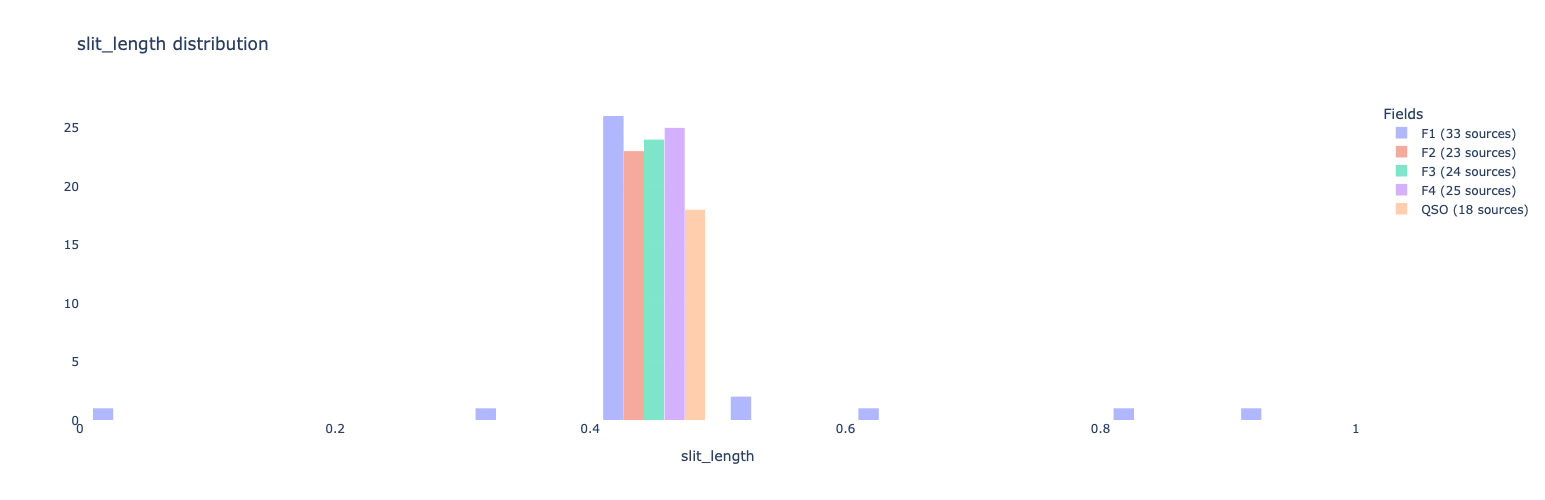

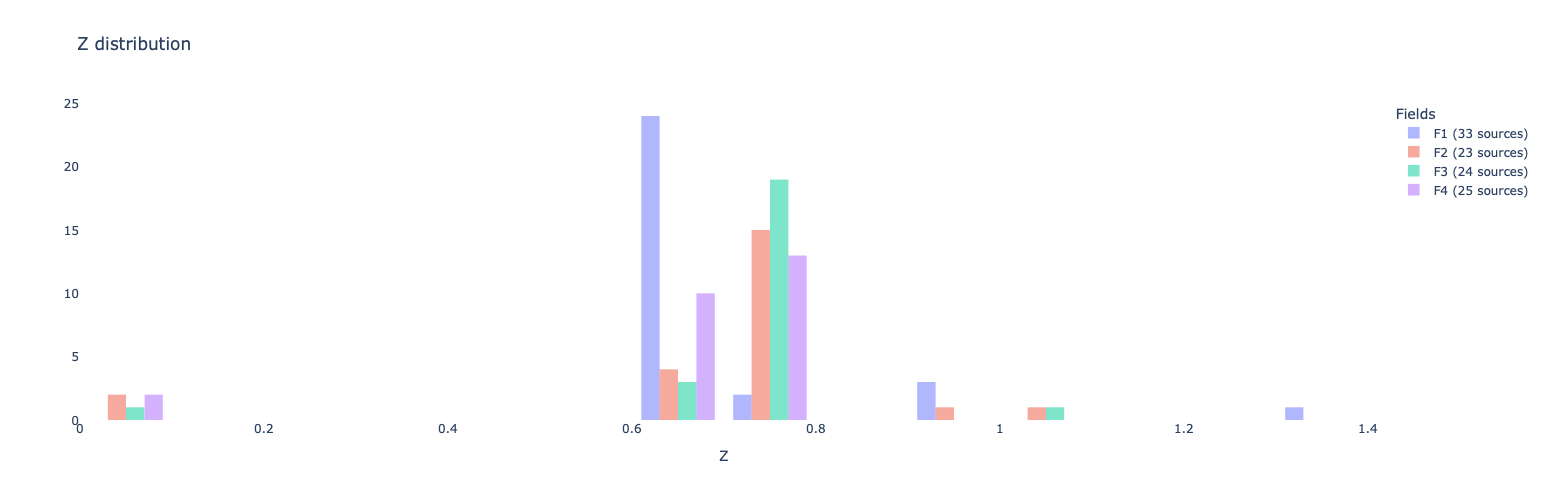

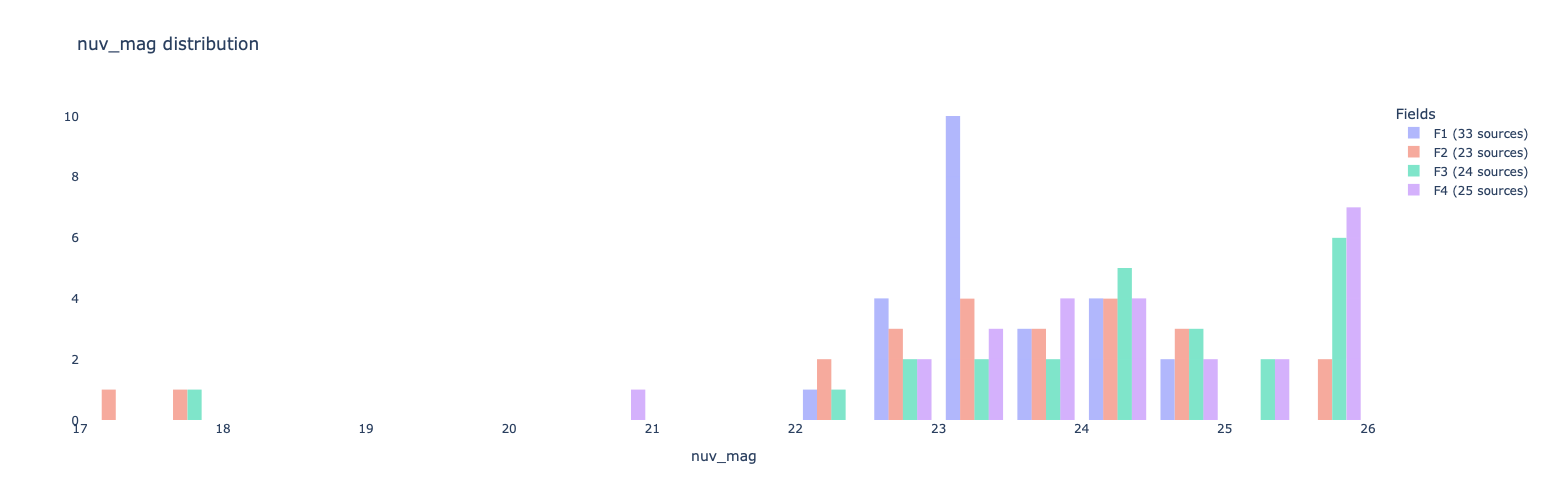

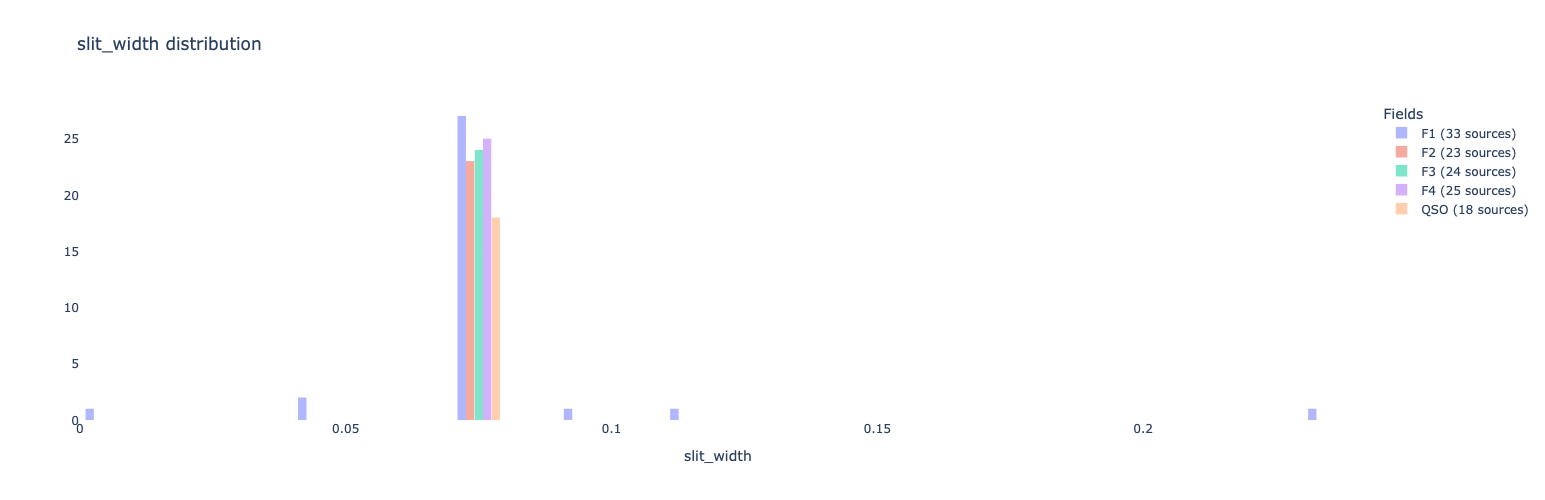

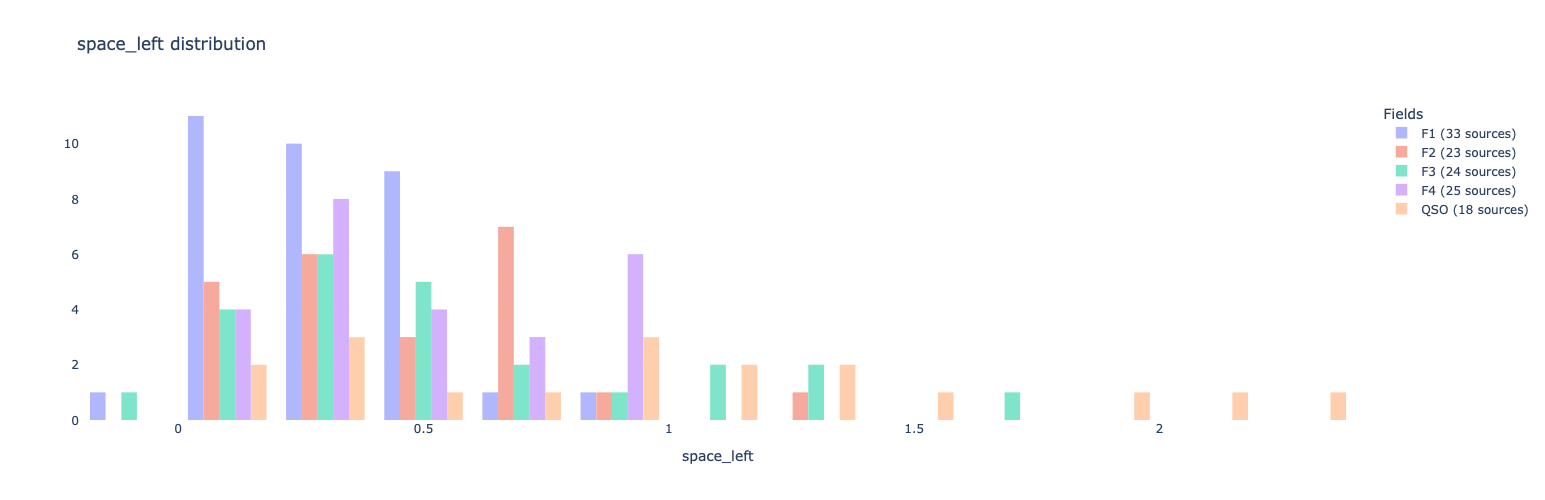

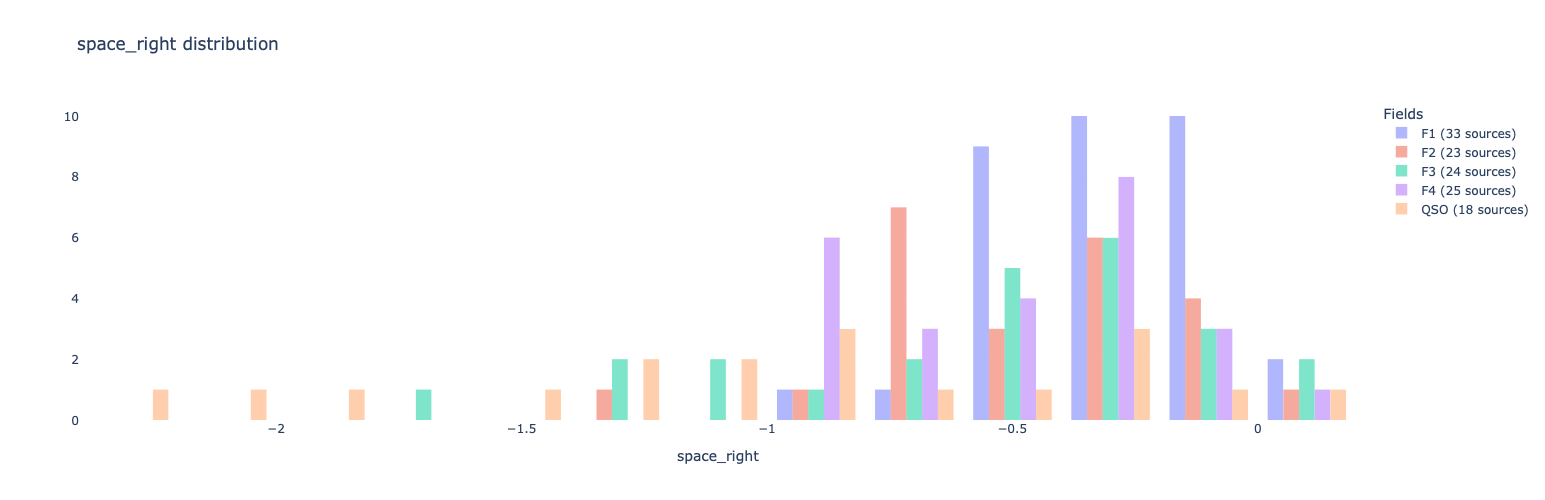

In [155]:
#"<a href=\'https://www.google.com/sky/#latitude=69.35708&longitude=-30.9375&zoom=7&Spitzer=0.00&ChandraXO=0.00&Galex=0.00&IRAS=0.00&WMAP=0.00&Cassini=0.00&slide=1&mI=-1&oI=-1'>+</a>"
plot_scatter_field([F1,F2,F3,F4,QSO],['F1','F2','F3','F4','QSO'],x='RA',y='DEC',marker_symbol='circle',marker=dict(size=30),mode='markers+text')
plot_histogram_field([F1,F2,F3,F4,QSO],['F1','F2','F3','F4','QSO'],value='slit_length', xbins=dict(start=0,end=2,size=0.1))  
plot_histogram_field([F1,F2,F3,F4,QSO],['F1','F2','F3','F4','QSO'],value='slit_length', xbins=dict(start=0,end=2,size=0.1))  
plot_histogram_field([F1,F2,F3,F4],['F1','F2','F3','F4'],value='Z', xbins=dict(start=0,end=2,size=0.1))  
plot_histogram_field([F1,F2,F3,F4],['F1','F2','F3','F4'],value='nuv_mag',xbins=dict(start=12,end=25.8,size=0.5))
plot_histogram_field([F1,F2,F3,F4,QSO],['F1','F2','F3','F4','QSO'],value='slit_width', xbins=dict(start=0,end=2,size=0.01))  




![SegmentLocal](1Septembre.jpg "segment")
![SegmentLocal](30Septembre.jpg "segment")
![SegmentLocal](targets.gif "segment")


